In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from services.UCHPathFinder import *

In [2]:
def loadLevelStatistics(levelName):

    path = LevelPathBuilder.getLevelDirectory(levelName)+'/01_TestStatistics.json'

    with open(path) as json_file:
        results = json.load(json_file)
        statistics = []
        for result in results:
            statistic = result[0]
            statistic['Id'] = 0
            if statistic['heuristic'] == 'GoalDistanceEuclidean':
                statistic['heuristic'] = 'Euclid'
            elif statistic['heuristic'] == 'GoalDistanceManhatten':
                statistic['heuristic'] = 'Manhattan'
            elif statistic['heuristic'] == 'GoalDistanceFlood':
                statistic['heuristic'] = 'Distance Heatmap'

            statistic['qF'] = ', '.join([str(v) for v in statistic['qF']])
            statistic['hF'] = ', '.join([str(round(v, 2)) for v in statistic['hF']])

            if statistic['hF'] == '0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99':
                statistic['hF'] = '0.9-0.99'


            if 'iterations' in statistic:
                statistic['iteration'] = statistic['iterations']
                statistic.pop('iterations')
            statistics.append(statistic)

            for i, row in enumerate(result[1:]):
            # for i, row in enumerate(reversed(result[1:])):
                row['levelName'] = levelName
                row['searchtime'] = row['time']
                row.update(statistic)
                row['time'] = row['length'] / 60
                row['Id'] = i + 1
                statistics.append(row)


        df = pd.DataFrame(statistics)
        if 'blocks' not in df.columns:
            df['blocks'] = 0

        return df

In [3]:
levelNames = sorted([
    '9DPV-UYUB',
    '9XX9-EEB4',
    '9ZKX-X199',
    'CVPH-JDJ2',
    'CWYY-0ZNT',

    'E5A2-703N',
    'KMBB-J3DJ',
    'N4NV-H5H4',
    'SDXC-TCU6',
    'VGCW-6BF7',
    'EA68-CTEG',

    # 'TallClimb',
    # 'TallClimb1',
    # 'JumpParcour5',
    # 'WireParcour'
])
levelNames

['9DPV-UYUB',
 '9XX9-EEB4',
 '9ZKX-X199',
 'CVPH-JDJ2',
 'CWYY-0ZNT',
 'E5A2-703N',
 'EA68-CTEG',
 'KMBB-J3DJ',
 'N4NV-H5H4',
 'SDXC-TCU6',
 'VGCW-6BF7']

In [4]:
data = []

for levelName in levelNames:
    path = LevelPathBuilder.getLevelDirectory(levelName, '01_TestStatistics.json')
    if os.path.exists(path):
        df = loadLevelStatistics(levelName)
        data.append(df)

df = pd.concat(data)

In [5]:
heuristics = ['Euclid', 'Manhattan', 'Distance Heatmap']
df['heuristic_sort'] = df['heuristic'].apply(lambda x: heuristics.index(x))
heuristics

['Euclid', 'Manhattan', 'Distance Heatmap']

In [6]:
hFactors = df.hF.unique().tolist()
df['hF_sort'] = df['hF'].apply(lambda x: hFactors.index(x))
hFactors

['0.5', '0.7', '0.9', '1.0', '0.5, 0.7, 0.9, 1']

In [7]:
qFactors = df.qF.unique().tolist()
df['qF_sort'] = df['qF'].apply(lambda x: qFactors.index(x))
qFactors

['1, 1', '3, 3']

In [8]:
def plotLevelStatistics(dfx, categoryCol, valueCol, aggFunction, yLabel, savePath):
    plt.subplots(figsize=(6, 5))

    dfx = dfx.sort_values(by=[categoryCol + '_sort'])
    categories = dfx[categoryCol].unique()
    
    dfx = dfx[['levelName', categoryCol, valueCol, categoryCol + '_sort']]

    dfx = dfx.groupby(['levelName', categoryCol]).agg(['min', 'max', 'median', 'mean']).reset_index()


    x = np.arange(len(levelNames))


    bar_width = 1 / (len(categories) + 1)
    totalWidth = bar_width * (len(categories) - 1)

    for cIdx, category in enumerate(categories):
        df0 = dfx[dfx[categoryCol] == category]
        for i, levelName in enumerate(levelNames):
            df0.loc[df0.levelName == levelName, 'levelNr'] = i

        x1 = df0.levelNr
        x1 = x1 - totalWidth / 2 + cIdx * bar_width

        plt.bar(x1, df0[valueCol][aggFunction], label=category, width=bar_width)

    # plt.xlabel('Level')
    plt.ylabel(yLabel)
    plt.xticks(x, levelNames, rotation=90)
    plt.legend()
    # plt.title(title)
    plt.tight_layout()
    plt.savefig(savePath, dpi=300)
    plt.grid(axis='y')


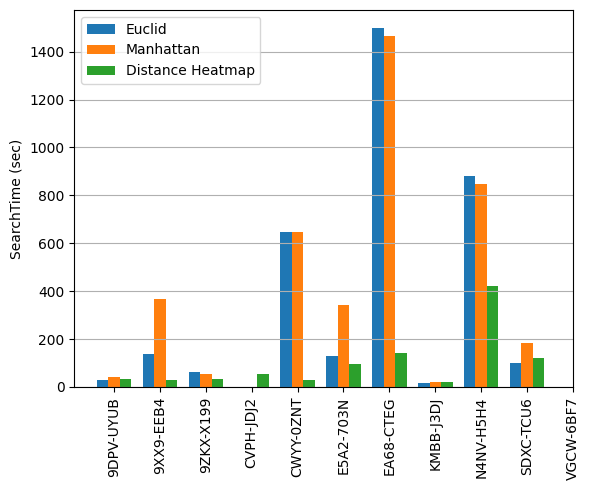

In [9]:
dfx = df[df.Id > 0]
# dfx = dfx[dfx.hF == '0.5, 0.7, 0.9, 1']
# dfx = dfx[dfx.qF == '1, 1']
plotLevelStatistics(
    dfx, 'heuristic', 'searchtime', 'min', 'SearchTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicSearchtime.png')

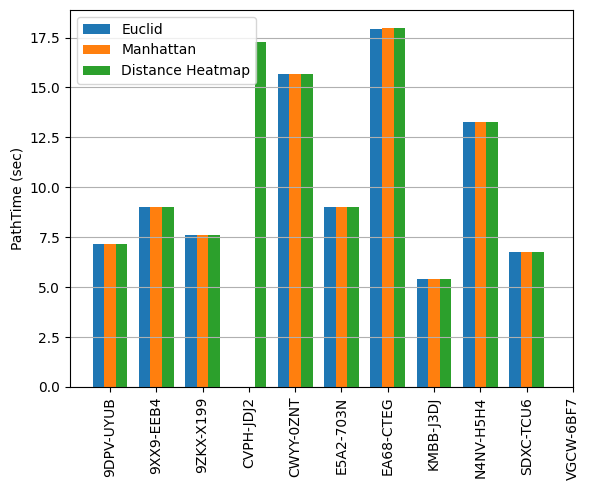

In [10]:
dfx = df[df.Id == 1]
# dfx = dfx[dfx.hF == '0.5, 0.7, 0.9, 1']
# dfx = dfx[dfx.qF == '1, 1']
plotLevelStatistics(dfx, 'heuristic', 'time', 'min', 'PathTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicFirst.png')

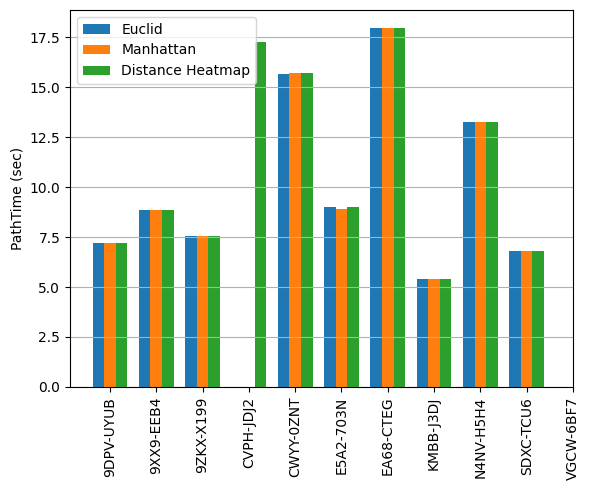

In [11]:
dfx = df[df.Id > 0]
# dfx = dfx[dfx.hF == '0.5, 0.7, 0.9, 1']
# dfx = dfx[dfx.qF == '1, 1']
plotLevelStatistics(dfx, 'heuristic', 'time', 'min', 'PathTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicBest.png')

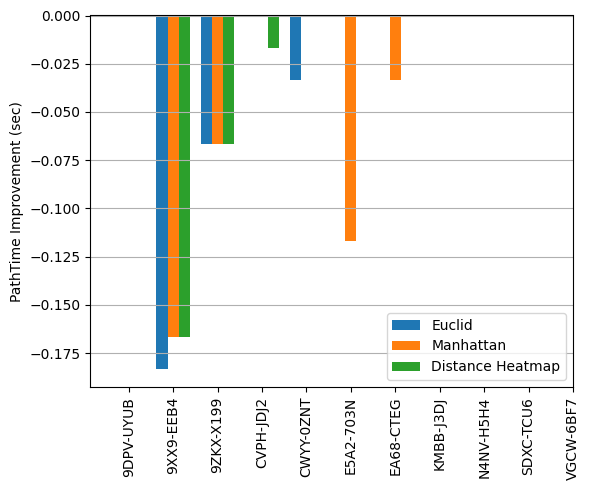

In [12]:
dfx0 = df[df.Id == 1][['levelName', 'heuristic', 'heuristic_sort', 'time']].groupby(['levelName', 'heuristic', 'heuristic_sort']).min().reset_index()
dfx = df[df.Id >= 1][['levelName', 'heuristic', 'heuristic_sort', 'time']].groupby(['levelName', 'heuristic', 'heuristic_sort']).min().reset_index()

dfx['time'] = dfx['time'] - dfx0['time']

plotLevelStatistics(dfx, 'heuristic', 'time', 'mean', 'PathTime Improvement (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicDiff.png')

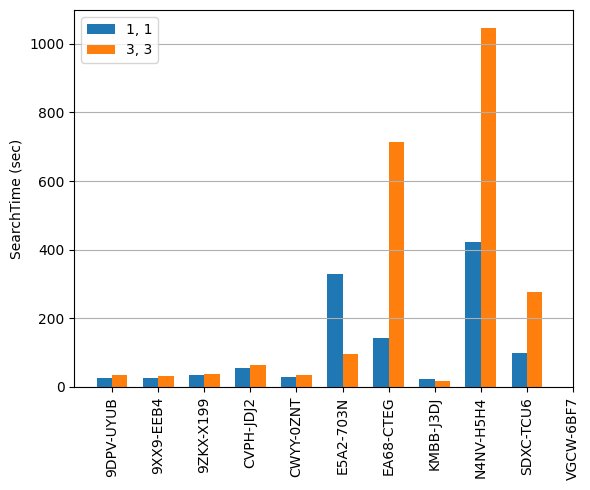

In [13]:
dfx = df[df.Id > 0]
# dfx = dfx[dfx.heuristic == 'Distance Heatmap']
# dfx = dfx[dfx.hF == '0.5, 0.7, 0.9, 1']
plotLevelStatistics(dfx, 'qF', 'searchtime', 'min', 'SearchTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_QuantizationSearchtime.png')

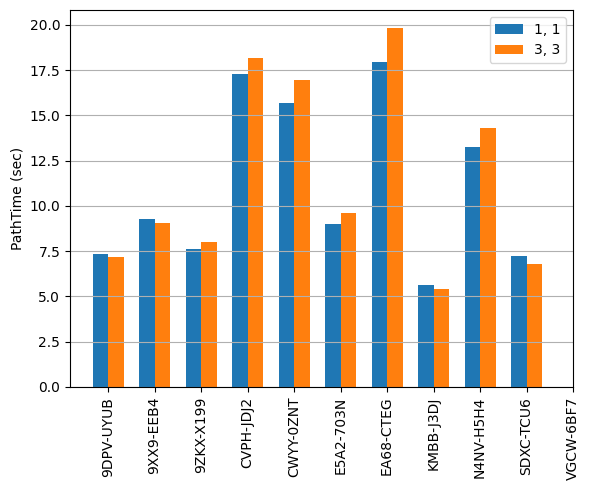

In [14]:
dfx = df[df.Id == 1]
# dfx = dfx[dfx.heuristic == 'Distance Heatmap']
# dfx = dfx[dfx.hF == '0.5, 0.7, 0.9, 1']
plotLevelStatistics(dfx, 'qF', 'time', 'min', 'PathTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_QuantizationFirst.png')


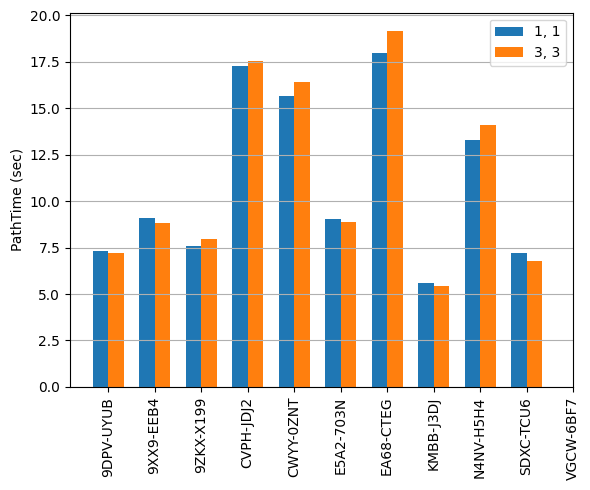

In [15]:
dfx = df[df.Id > 0]
# dfx = dfx[dfx.heuristic == 'Distance Heatmap']
# dfx = dfx[dfx.hF == '0.5, 0.7, 0.9, 1']
plotLevelStatistics(dfx, 'qF', 'time', 'min', 'PathTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_QuantizationBest.png')


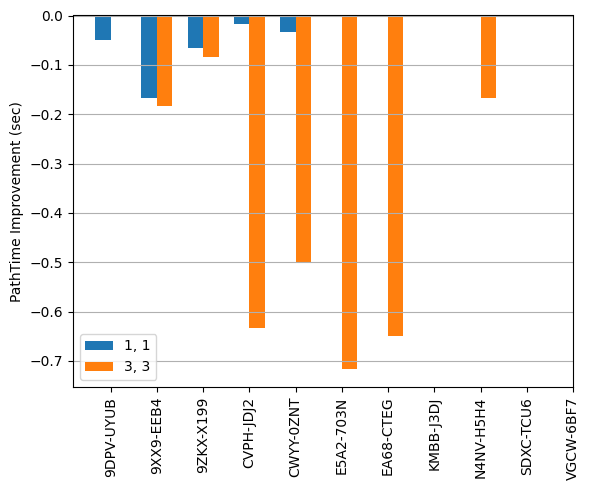

In [16]:
dfx0 = df[df.Id == 1][['levelName', 'qF', 'qF_sort', 'time']].groupby(['levelName', 'qF', 'qF_sort']).min().reset_index()
dfx = df[df.Id >= 1][['levelName', 'qF', 'qF_sort', 'time']].groupby(['levelName', 'qF', 'qF_sort']).min().reset_index()

dfx['time'] = dfx['time'] - dfx0['time']

plotLevelStatistics(dfx, 'qF', 'time', 'mean', 'PathTime Improvement (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_QuantizationDiff.png')

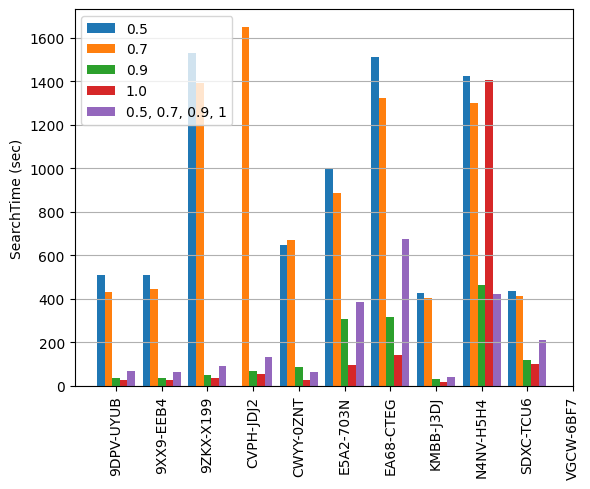

In [17]:
dfx = df[df.Id > 0]
# dfx = dfx[dfx.heuristic == 'Distance Heatmap']
# dfx = dfx[dfx.qF == '1, 1']

plotLevelStatistics(dfx, 'hF', 'searchtime', 'min', 'SearchTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicFactorSearchtime.png')

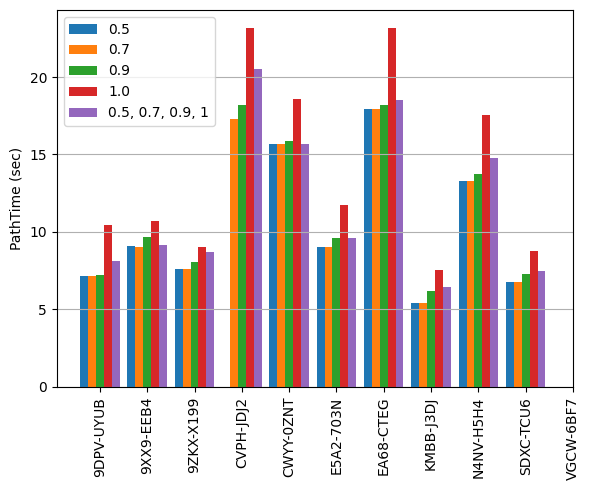

In [18]:
dfx = df[df.Id == 1]
# dfx = dfx[dfx.heuristic == 'Distance Heatmap']
# dfx = dfx[dfx.qF == '1, 1']
plotLevelStatistics(dfx, 'hF', 'time', 'min', 'PathTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicFactorFirst.png')

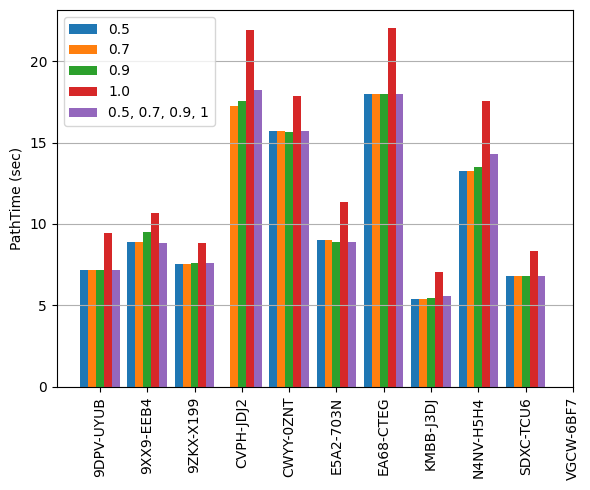

In [19]:
dfx = df[df.Id > 0]
# dfx = dfx[dfx.heuristic == 'Distance Heatmap']
# dfx = dfx[dfx.qF == '1, 1']
plotLevelStatistics(dfx, 'hF', 'time', 'min', 'PathTime (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicFactorBest.png')

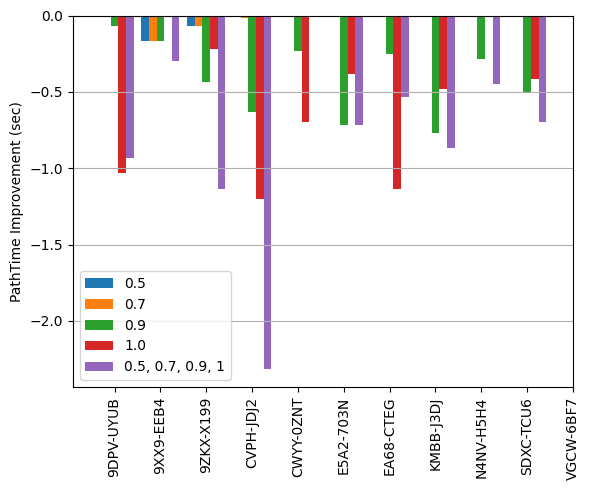

In [20]:
dfx0 = df[df.Id == 1][['levelName', 'hF', 'hF_sort', 'time']].groupby(['levelName', 'hF', 'hF_sort']).min().reset_index()
dfx = df[df.Id >= 1][['levelName', 'hF', 'hF_sort', 'time']].groupby(['levelName', 'hF', 'hF_sort']).min().reset_index()

dfx['time'] = dfx['time'] - dfx0['time']

plotLevelStatistics(dfx, 'hF', 'time', 'mean', 'PathTime Improvement (sec)',
    savePath=f'{dataAnalysisRoot}/TestResultPlots/LevelResults_HeuristicFactorDiff.png')

In [21]:
df[df.Id == 1]['time']

1       7.36667
4       7.55000
7       8.03333
23     10.78333
54      8.11667
         ...   
119     6.78333
121     6.78333
123     7.58333
129     9.38333
138     7.48333
Name: time, Length: 219, dtype: float64